# m.5.ASSIGNment → Spooky authorship identification via Apache Spark

### Group 6: Tyler Earps, Basil Mullings, Ryan Smith, and Ean Vandergraaf

| Overview      | Use Apache Spark and machine learning to determine sentence authorship labels. |
| ------------- | ------------------------------------------------------------------------------ |
| Data          | https://www.kaggle.com/competitions/spooky-author-identification/code          |


<figure>
    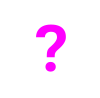
    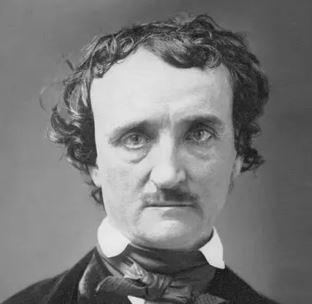
    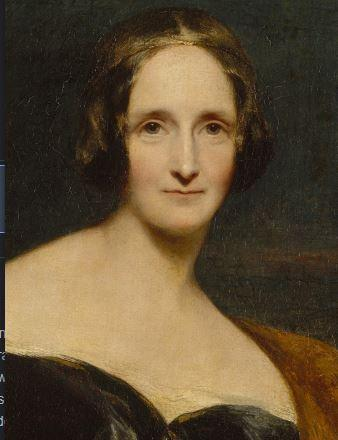
    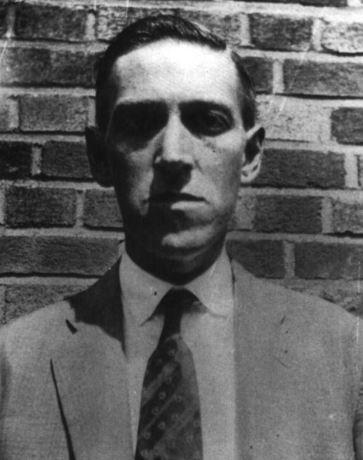
</figure>


## DETAILS

**Dataset Description**: The spooky author identification dataset contains text from works of
fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary
Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt
sentence tokenizer resulting in an odd non-sentence here and there. Your objective is to
accurately identify the author of the sentences in the test set.

- **id** - unique identifier for each sentence
- **text** - sentence written by one of the authors
- **author** - {EAP:Edgar Allan Poe}, {HPL:HP Lovecraft}; {MWS:Mary Wollstonecraft Shelley}

**Objective**:
1. Accurately identify the author of the sentences in the test set.
2. Perform ALL work using Apache Spark.

**Dataset**:
- Training consists of passages with an author label.
- Test has sentences with no author labels.

**Competition Evaluation**: The submissions were evaluated based on multi-class logarithmic loss.
The logarithmic loss assesses the uncertainty of the predicted probabilities, penalizing
confident incorrect predictions. Lower log loss values indicated better performance.

**Approach**: NLP techniques + machine learning algorithms. Feature engineering like bag-of-words,
TF-IDF, word embeddings/Word2Vec. Perform algorithmic work with logistic regression, support
vector machines, neural networks, and as appropriate.

## TASKS

### Stage 0: Import Data

1. Create a code notebook called: code_6_of_10_data_mine_<your_name>.ipynb
2. Load data into Spark data objects and explore structure, size, and distribution of information.

In [102]:
# Download the data
# If you haven't installed the Kaggle API, uncomment the line below to do so
#%pip install kaggle
#!pip install kaggle
#!kaggle competitions download -c spooky-author-identification -p data/

In [89]:
import zipfile
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, countDistinct, format_number, when, col, explode, lower

# Extract the CSV files
data_path = "data"
if not Path(f"{data_path}/test.zip").is_file():
    with zipfile.ZipFile(f"{data_path}/spooky-author-identification.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/train.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/test.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")

#Create a SparkSession
spark = SparkSession.builder.getOrCreate()

#Load Kaggle data into a DataFrame
df_train = spark.read.format("csv").option("header", "true").option('escape','"').load(f"{data_path}/train.csv")
df_test = spark.read.format("csv").option("header", "true").option('escape','"').load(f"{data_path}/test.csv")

# Show the data
print('#=> Train Data:')
df_train.show(5)
print("\n")

print('#=> Test Data:')
df_test.show(5)
print("\n")

#
###We'll focus on the train data for now, and will use it for most of our activities - including our train/test split.
###Later, wer'll use the test data (df_test) as our validation dataset to validate our models.
#

##Show our basic statistics
print('#=> Summary of statistics for our Training data :')
df_train.summary().show()
print("\n")

##Show the data schema
print('#=> Training data schema:')
df_train.printSchema()
print("\n")


##List the column names 
print('#=> Column names:')
print(df_train.columns)
print("\n")


##Verify any null relevant data in any of our columns.
print('#=> Training dataset with Null values:')
df_train.select([count(when(col(c).isNull(), c )).alias(c) for c in df_train.columns]).show()
print("\n")





#=> Train Data:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



#=> Test Data:
+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



#=> Summary of statistics for our Training data :
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NU

### Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

3. Perform exploratory data analysis and create visualizations and tables as needed.
4. Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data.
    1. Tokenize - split the text into individual words aka tokens.
    2. Remove stop.words - frequently used pronouns and personal references.
        1. Top ten include: I, you, he, she, it, we, they, me, him, her
    3. Lemmatization - convert words to their root (optional).
        1. Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes.

#=> EDA
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

Texts by Edgar Allan Poe: 7900 (40.3%)
Texts by H. P. Lovecraft: 5635 (28.8%)
Texts by Mary W. Shelley: 6044 (30.9%)


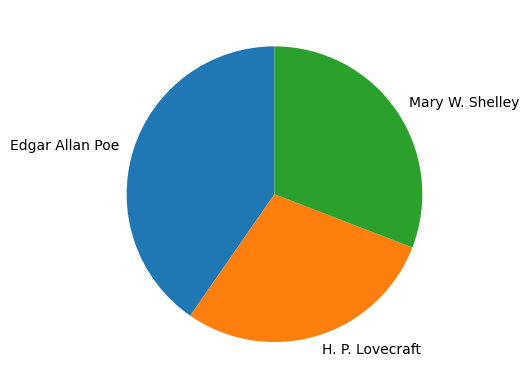

Tokens: ['this', 'process', 'however', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', 'as', 'i', 'might', 'make', 'its', 'circuit', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out', 'without', 'being', 'aware', 'of', 'the', 'fact', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall']


Filtered tokens: ['process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']


#=> A few rows of tokenized train data:
+-------+--------------------+------+--------------------+--------------------+
|     id|                text|author|              tokens|     filtered_tokens|
+-------+--------------------+------+--------------------+--------------------+
|id26305|This process howe...|   EAP|[this, process, h...|[process, however...|
|id17569|It never once occ...|   HPL|[it, n

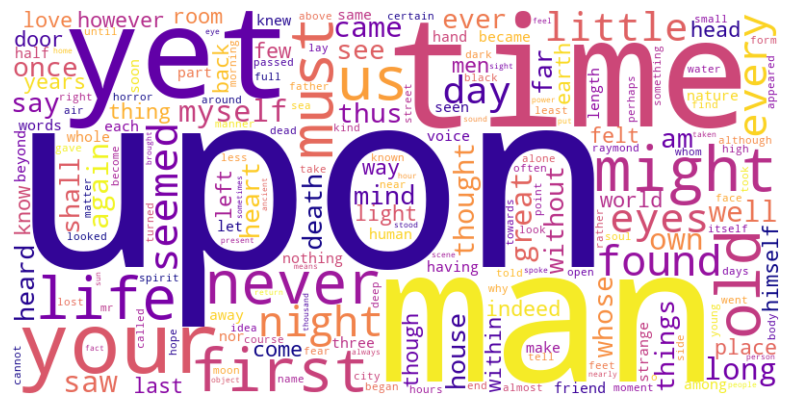

In [81]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.sql.functions import regexp_replace
import csv
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

authors = {
    'EAP': 'Edgar Allan Poe',
    'HPL': 'H. P. Lovecraft',
    'MWS': 'Mary W. Shelley'
}

# Perform EDA
print('#=> EDA')
df_train.describe().show()
eap_count = df_train.filter("author == 'EAP'").count()
hpl_count = df_train.filter("author == 'HPL'").count()
mws_count = df_train.filter("author == 'MWS'").count()
print(f"Texts by Edgar Allan Poe: {eap_count} ({round(100 * eap_count / df_train.count(), 1)}%)")
print(f"Texts by H. P. Lovecraft: {hpl_count} ({round(100 * hpl_count / df_train.count(), 1)}%)")
print(f"Texts by Mary W. Shelley: {mws_count} ({round(100 * mws_count / df_train.count(), 1)}%)")

# Breakdown of authors
y = np.array([eap_count, hpl_count, mws_count])
labels = [authors['EAP'], authors['HPL'], authors['MWS']]
plt.pie(y, labels = labels, startangle=90)
plt.show() 

# Step 1: Tokenization
# Strip punctuation from text
df_train_no_punctuation = df_train.withColumn('text', regexp_replace('text', '[^\\w\\d\\s]', ''))
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df_train_tokenized = tokenizer.transform(df_train_no_punctuation)
print(f"Tokens: {df_train_tokenized.head()["tokens"]}")
print("\n")

# Step 2: Stopword removal
# List of stopwords compiled from the Gigaword corpus by Dr. George Wilson of Georgetown University: https://faculty.georgetown.edu/wilsong/IR/WD3.html
with open('stopwords.csv', newline='') as csvfile:
    stopword_reader = csv.reader(csvfile, delimiter=',')
    next(stopword_reader, None)  # Skip header
    stopwords = [row[2] for row in stopword_reader]
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords)
df_train_no_stopwords = stopwords_remover.transform(df_train_tokenized)
print(f"Filtered tokens: {df_train_no_stopwords.head()["filtered_tokens"]}")

##List a few rows from our now tokenized train dataa
print("\n")
print('#=> A few rows of tokenized train data:')
df_train_no_stopwords.show(10)

##Explode the 'filtered_tokens' column to get individual words in separate rows
words_exploded = df_train_no_stopwords.withColumn("each_word", explode(col("filtered_tokens")))

##Count the occurrences of each word
word_count = words_exploded.groupBy("each_word").count()

##Now show the result
print("\n")
print('#=> Displaying word count:')
word_count.orderBy(col("count").desc()).show(5)

#
###Create a wordcloud from the word counts obtained.
#
##Convert the PySpark DataFrame to Pandas DataFrame
df_word_count_pd = word_count.toPandas()

##Convert the Pandas DataFrame to a dictionary of word counts
word_freq_dict = dict(zip(df_word_count_pd['each_word'], df_word_count_pd['count']))

##Now create and display the word cloud
print("\n")
print('#=> Displaying wordcloud:')

##Now create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'plasma').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Stage 2: Feature Extraction

5. Perform TF-IDF to quantify word importance <[term.frequency.inverse.doc.frequency](https://en.wikipedia.org/wiki/Tf–idf)>
6. Normalize is scaling or standardizing the numerical features to a standard range or distribution.
    1. In text mining, normalization vectorizes features with methods like TF-IDF, a numerical
measurement, to ensure a consistent scale.
    2. It handles variations in the magnitude of feature values impacting machine-learning algorithm
performance. Normalize the features to ensure a similar scale and prevent features with larger
values from dominating the analysis or modeling process.

In [93]:
# Step 3: Feature extraction, including TF-IDF calculation
##

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer

#Convert words to vectors of token counts. 
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")

##TF-IDF frequency scores regarding the importance of words.
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

##Normalize the tfidf scores.
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized")

##Convert authors names to numerical labels
indexer = StringIndexer(inputCol="author", outputCol="label")

##Create a pipeline to be used later when training the ML. 
pipeline = Pipeline(stages=[count_vectorizer, idf, normalizer, indexer])

##Fit the pipeline and transform the training dataset
pipeline_model = pipeline.fit(df_train_no_stopwords)
train_processed_data = pipeline_model.transform(df_train_no_stopwords)

##Now display 2 rows of the processed train data.
print("\n")
print('#=> Displaying processed train data:')
train_processed_data.show(n=2, truncate=False)


##Convert the text field to lowercase, and also remove any special characters
train_cleaned_data = train_processed_data.withColumn("cleaned_text", regexp_replace(lower(col("text")), "[^a-zA-Z0-9\\s]", ""))
#train_cleaned_data.show(2)





#=> Displaying processed train data:
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------

### Stage 3: Machine Learning

7. Perform train/test split.
8. Perform algorithmic analysis to assess and predict test labels.
    1. Use as many algorithms as you need to get a good answer.
    2. Supervised: logistic regression, random forest, support vector machines, etc.
    3. Unsupervised: K-means, dimensionality reduction, PCA, etc.

### Stage 4: Evaluation & Visualization

9. Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score.
10. Visualize confusion matrix, correlations, and similar.
11. Identify important features contributing to classification.
12. Write a 2-3 sentence minimum of findings, learnings, and what you would do next.

In [99]:
##Stage 3 - Machine Learning.
#
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes

##Stage 3.7 - Perform our train/test split
##Split the training data into training and test sets (80% training, 20% test)
X_train, X_test = train_cleaned_data.randomSplit([0.8, 0.2], seed=42)

##Our list of ML models
ml_models = {
    "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

##Catalog the "author" prediction results of our models.
results = {}
for model_name, model in ml_models.items():
    
    ##Proceed to train the model.
    trained_model = model.fit(X_train)

    ##Do the prediction
    y_pred = trained_model.transform(X_test)

    ##Do the evaluation.
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(y_pred)
    results[model_name] = { "accuracy": accuracy, "y_pred": y_pred }
    print(f"{model_name}: {accuracy=}")

    ##Check the predictions.
    y_pred.select("label", "prediction").show(5)

highest_accuracy = 0
best_performing_model = ""

##Now traverse our results dictionary and find the highest accuracy of each of our model.
for model_name, result in results.items():
    if result["accuracy"] > highest_accuracy:
        highest_accuracy = result["accuracy"]
        best_performing_model = model_name

print(f'The Best performing model: {best_model}={highest_accuracy}')


randomForest_model: accuracy=0.43016325472920447
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  2.0|       0.0|
+-----+----------+
only showing top 5 rows

decisionTree_model: accuracy=0.44959834153925887
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  2.0|       0.0|
+-----+----------+
only showing top 5 rows

logisticReg_model: accuracy=0.7312775330396476
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       2.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  2.0|       2.0|
+-----+----------+
only showing top 5 rows

naive_bayes_model: accuracy=0.8209380668566987
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  2.0|       2.0|
+-----+----------+
only showing top 5 rows

The Best performing mode

In [ ]:
###Stage 4 - Evaluation & Visualization.




    1. Tokenizer to split part of the pyspark.ml.feature module
    2. StopWordsRemover in the pyspark.ml.feature module.
    3. lemmatization - PySpark does not have a built-in lemmatization use User-Defined
    Functions UDF to create.
    4. normalize like convert text to lowercase; remove special characters with PySpark user
    defined functions <UDF> or built-in string functions like lower() or regexp_replace().
    5. tf.idf PySpark's CountVectorizer and IDF class compute tf.idf for text feature
    extraction.

#### Resources
- [How to Assess Algorithm Fit](https://github.com/cosc-526/home.page/blob/86eac9b60052cdb5959c0e9fa96b7e7f3a3fcdd9/how.To.M.5.algorithm.Assess.fit.super.unsuper.pdf)
- [PySpark Code Dictionary](https://github.com/cosc-526/home.page/blob/2d9505d38a2b76ce61991fc59223f511aef34472/reference.library.pyspark.code.dictionary.pdf)
- [pd.DataFrame vs. rdd.DataFrame](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.RDD.feng.utk.pdf)
- [Cheat Sheet for PySpark](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.feng.utk.pdf)
- [Additional PySpark Guide](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.python.feng.utk.pdf)
- [Cheat Sheet for LaTeX](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.LaTeX.feng.utk.pdf)
- [Apache Spark Source Documentation](https://spark.apache.org/docs/latest/index.html)
- Feng, W. (2021). [Learning Apache Spark with Python](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf). GitHub.

#### Additional Resources
- Feng, W., & Chen, M. (2017). [Learning Apache Spark](https://mingchen0919.github.io/learning-apache-spark/index.html). GitHub.
- Karau, H., Konwinski, A., Wendell, P., & Zaharia, M. (2015). Learning Spark: Lightning-fast
big data analysis. O’Reilly Media, Inc.
- Kirillov, A. (2016). [Apache Spark: Core concepts, architecture and internals](http://datastrophic.io/core-concepts-architecture-and-internals-of-apache-spark/).
Datastrophic.
